# CEC1702 RSA GLITCHING

In [9]:
#adjust notebook size 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 1. Connecting to ChipWhisperer and CEC1702

### Import CW and default setup 

In [8]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
SS_VER='SS_VER_1_1'
import chipwhisperer as cw
print(".Import DONE")
scope = cw.scope()
print("..Scope set")
target = cw.target(scope, cw.targets.SimpleSerial) #cw.targets.SimpleSerial can be omitted
print("...Target set")
scope.default_setup()
print("....Scope setup done")

.Import DONE
..Scope set
...Target set
....Scope setup done


### Scope setup

#### ⚠ Ensure J3 on UFO Board routines CLKFB to HS1/IN ( the lowest jumper!) ⚠
****
#### CEC1702 must be programmed externaly using Flash Programmer


In [9]:
import time

def setup_scope_for_glitching():
    scope.adc.basic_mode = "rising_edge"
    scope.clock.clkgen_src = "system"    #ChipWhisperer-Lite CLK
    scope.clock.adc_src = "clkgen_x1"    #Only for ADC
    scope.clock.freq_ctr_src = "clkgen"  #ChipWhisperer-Lite CLK, not neccessary
    scope.clock.clkgen_freq = 48_000_000
    time.sleep(1.5)
    scope.io.hs2 = None
    
setup_scope_for_glitching()  
print(scope.clock)
print("\033[1m***********************************************\033[0m")
print(f"\033[1mSample rate = {scope.clock.freq_ctr} Hz")        
print(f"Target baudrate = {target.baud}\033[0m")

adc_src       = clkgen_x1
adc_phase     = 0
adc_freq      = 48000000
adc_rate      = 48000000.0
adc_locked    = True
freq_ctr      = 48000000
freq_ctr_src  = clkgen
clkgen_src    = system
extclk_freq   = 10000000
clkgen_mul    = 2
clkgen_div    = 4
clkgen_freq   = 48000000.0
clkgen_locked = True

***********************************************
Sample rate = 48000000 Hz
Target baudrate = 38400


#### Function definition for device rebooting/reseting

In [10]:
import time
def reboot_flush():            
    scope.io.nrst = False
    time.sleep(0.5)
    scope.io.nrst = "high_z"
    time.sleep(0.3)
    #Flush garbage too
    target.flush()

reboot_flush()
print(scope.clock)

adc_src       = clkgen_x1
adc_phase     = 0
adc_freq      = 48000000
adc_rate      = 48000000.0
adc_locked    = True
freq_ctr      = 48000000
freq_ctr_src  = clkgen
clkgen_src    = system
extclk_freq   = 10000000
clkgen_mul    = 2
clkgen_div    = 4
clkgen_freq   = 48000000.0
clkgen_locked = True



## 2. Test CEC1702 communication and decryption


In [11]:
import time
reboot_flush()
target.flush()
scope.arm()

for i in range(1):
    tak = time.perf_counter()
    target.simpleserial_write("c", bytearray([]))
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    output = target.simpleserial_read_witherrors('r', 48, timeout=0)
    tik = time.perf_counter()
    print(f"CT decrypted in {tik - tak:0.4f} seconds")

    dec_msg = None
    if output['valid']:
        dec_msg = output['payload']
    else:
        print ("output is NOT valid")
        print (output)

    target.simpleserial_write("1", bytearray())
    time.sleep(0.2)
    output = target.simpleserial_read_witherrors('r', 48, timeout=10)
    if output['valid']:
        dec_msg.extend(output['payload'])

    target.simpleserial_write("2", bytearray())
    time.sleep(0.2)
    output = target.simpleserial_read_witherrors('r', 32, timeout=10)
    if output['valid']:
        dec_msg.extend(output['payload'])

    print(f"scope.adc.trig_count = {scope.adc.trig_count}")
    print(f"decrypted message = {dec_msg}")

CT decrypted in 0.0322 seconds
scope.adc.trig_count = 154757
decrypted message = CWbytearray(b'11 14 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 12 34 56 11 14 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 12 34 56')


## 3. Scope setup for successful Voltage glitching

In [12]:
scope.glitch.clk_src = "clkgen" # set glitch input clock
scope.glitch.output = "glitch_only" # glitch_out = clk ^ glitch
scope.glitch.trigger_src = "ext_single" # glitch only after scope.arm() called
scope.io.glitch_hp = True
scope.io.glitch_lp = True

## 4. Glitching loop

In [13]:
import time

def reboot_UFO_board(ext_offset):
    scope.io.target_pwr = False
    time.sleep(0.1)
    print(f"Rebooted:EO = {scope.glitch.ext_offset}")
    scope.io.target_pwr = True
    time.sleep(0.2)
    
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)
    
def egcd(a, b):
    x,y, u,v = 0,1, 1,0
    while a != 0:
        q, r = b//a, b%a
        m, n = x-u*q, y-v*q
        b,a, x,y, u,v = a,r, u,v, m,n
        gcd = b
    return gcd, x, y

# First key
n = 0x9292758453063D803DD603D5E777D7888ED1D5BF35786190FA2F23EBC0848AEADDA92CA6C3D80B32C4D109BE0F36D6AE7130B9CED7ACDF54CFC7555AC14EEBAB93A89813FBF3C4F8066D2D800F7C38A81AE31942917403FF4946B0A83D3D3E05EE57C6F5F5606FB5D4BC6CD34EE0801A5E94BB77B07507233A0BC7BAC8F90F79
e = 0x10001
c = 0x1701e0c7306e79a3fbef9c26b12c072b2f33b613941978404067e9484859eba18669e1003a61e05b91f106d16f749b52afdc5b66ccf2faa75d630694dd2b425f6bcd8d896bd1f7f15f65dd64dcaa17f1f3b826ec78d66d452132cae92d35b642146acdd4b7cf218a42b57122149cd98a13c9018cd99ecde00a699c5d6cf59666

#Second key
# n = 0x9eab7db8579116b680287dbb381ebd361767eeb2336a2b6fa03785918a816a299bb2cd43deb3ad4edff4e6c4596d948936cd62d9d52eb247b56c2c0779b9797b55bac985266f4b9866314d547c46c201e71140bb15e573893d3702460afce8b1931f63bf61548e45a7d395817ed84f6fdd5ba402bc48789cc760028e8184fc2b
# e = 0x10001
# c = 0x3b2288af3257735f8124b95cd410ff8beafa8c3969dcf1df8c92f6db59356c4621d6dc406dc17317657492a7e00d5d51ea81a4722dfe459b48315b8a7dc75a4cffb9835e9fa2cef6c903f2b294f486d5655dd35a407f8dd43dc1e3389fdcdf20b850a794fc845b616113ca9b5f8dff8df22b4c4f90469476fe800dcfbbb111a1

#Third key
# n = 0xa9616a47156dc27eff77bf987cc938bb453783f2ac1cf12c54800edaa81ecb099038e01c5d3246b9eed85f96d2ea47f742b64059b20736a8302163ceffc1cc73715443a029d44787cc3f1ec18c08c16ae7b0acd33bc944e833b977d5a68fe1664bd96698584ffe4d7c7a8fb15fa1727a1d8e90379f56635bd7d2bfefc65c8af3
# e = 0x10001
# c = 0x669142754d8e0ba84829daa41fd8ebe1052ec069e89fe0f8559af91b7c2bac04e2b0bfd87248989738dea3a90beafd4f126164a31acf99189f1e1f7460f6730a7faf66d6208980723ddbad6b0dd06da6883aed9591e39f50c1cc4110e80a9f008da478d8ec27941b7b9c67e3a68cb4ce54a6386158f41f5b837ff15e9d738180


def recover_key(glitched_m) :
    glitched_dec_msg_int = mpz(int.from_bytes(glitched_m, "big"))
    try: 
        q_test = gmpy2.gcd(c - glitched_dec_msg_int**e, n)
    except:
        print("GCD ERROR OCCURED")
        q_test = 1
    p_test = n//q_test
    phi = (q_test - 1)*(p_test - 1)
    gcd, d, b = egcd(e, phi)
    computed_msg = pow(c, d, n)
    correct_dec_msg_int = int.from_bytes(dec_msg, "big")
#     print("----Acquired secret key parameters---")
#     print(f"Q = {hex(q_test)}")
#     print(f"P = {hex(p_test)}")
    if computed_msg == correct_dec_msg_int:
#         print(f"M'= {hex(glitched_dec_msg_int)}")
#         print(f"D = {hex(d)}")
#         print("---- C^D mod N = M ?----")
#         print(f"C^D mod N = {hex(computed_msg)}")
#         print(f"        M = {hex(correct_dec_msg_int)}\n")
#         print ("Glitching was successful! Both messages are the same")
        return True
    else:
#         print ("Glitching was  NOT successful! Messages are different")
        return False

In [14]:
import matplotlib.pylab as plt
from importlib import reload
import chipwhisperer.common.results.glitch as glitch
from tqdm.notebook import trange
import struct
from math import gcd
import gmpy2
from gmpy2 import mpz
import time

gc = glitch.GlitchController(groups=["success", "reset", "normal", "false", "UFO_reset"], parameters=["width", "offset", "ext_offset"])
gc.display_stats()

succesful_offsets = []

g_step = 1
OFFSET_START =  0
OFFSET_END   = 75000
gc.set_range("width", 48, 48)
gc.set_range("offset", -44, -44)
gc.set_range("ext_offset", OFFSET_START, OFFSET_END)
scope.glitch.repeat = 9

gc.set_global_step(g_step)
scope.adc.timeout = 1
reboot_flush()

#some magic numbers here don't know why not corresponding with ms according a documentati
enc_timeout = 2000

total_success = 0
total_reset = 0
total_normal = 0
total_duration = 0
total_false_success = 0
total_UFO_reset = 0
resets_in_series = 0
loop_start_time = time.time()
time_to_proccess_1000_offsets_old = time.time()

for glitch_setting in gc.glitch_values():
    scope.glitch.width      = glitch_setting[0]
    scope.glitch.offset     = glitch_setting[1]
    scope.glitch.ext_offset = glitch_setting[2]
    
    for i in range(1):
        if resets_in_series > 3:
            reboot_UFO_board(glitch_setting[2])
            gc.add("UFO_reset", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
            resets_in_series = 0
            total_UFO_reset += 1
            
        tak = time.perf_counter() 
        target.flush()
        scope.adc.timeout = 0.5
        scope.arm()
        target.simpleserial_write("c", bytearray([]))
        ret = scope.capture()

        if ret:
            print('Timeout happened during acquisition')
            gc.add("reset", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
            total_reset += 1
            resets_in_series += 1
            reboot_flush()
            continue


        output = target.simpleserial_read_witherrors('r', 48, timeout=enc_timeout, glitch_timeout=1000)

        scope.io.glitch_hp = False
        scope.io.glitch_hp = True
        scope.io.glitch_lp = False
        scope.io.glitch_lp = True

        if output['valid'] is False:
            gc.add("reset", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
            total_reset += 1
            resets_in_series += 1
            reboot_flush()
            continue
        else:
            glitched_dec_msg = output['payload']
            target.simpleserial_write("1", bytearray())
            output = target.simpleserial_read_witherrors('r', 48, timeout=100)
            
            if output['valid']:
                glitched_dec_msg.extend(output['payload'])
            else:
                print("couldn't read 1 cmd")
                total_reset += 1
                resets_in_series += 1
                continue

            target.simpleserial_write("2", bytearray())
            output = target.simpleserial_read_witherrors('r', 32, timeout=100)
            if output['valid']:
                glitched_dec_msg.extend(output['payload'])
            else:
                print("Couldn't read 2 cmd")
                total_reset += 1
                resets_in_series += 1
                continue

            #use "dec_msg" variable from previous part.    
            if glitched_dec_msg != dec_msg: #detect if the calculation was messed up
#                 print(f"glitched_dec_msg: {glitched_dec_msg}")
#                 print(f"         dec_msg: {dec_msg}")
                tik = time.perf_counter()
                resets_in_series = 0
                if recover_key(glitched_dec_msg) == True:
#                     print(f"Glitched - W={scope.glitch.width}, O={scope.glitch.offset}, EO={scope.glitch.ext_offset}")
                    gc.add("success", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
                    succesful_offsets.append(scope.glitch.ext_offset)
                    total_success += 1
                    total_duration += (tik -tak)
                else:
                    gc.add("false", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
                    total_false_success += 1
            else:
                total_normal += 1
                resets_in_series = 0
                gc.add("normal", (scope.glitch.width, scope.glitch.offset, scope.glitch.ext_offset))
            
#             print(scope.glitch.ext_offset % 100)
#             if (scope.glitch.ext_offset % 1000) == 0:
#                 time_to_proccess_1000_offsets_new = time.time()
#                 print(f"Duration |{scope.glitch.ext_offset - 1000} - {scope.glitch.ext_offset}| = {timer(time_to_proccess_1000_offsets_old, time_to_proccess_1000_offsets_new)}")
#                 time_to_proccess_1000_offsets_old = time_to_proccess_1000_offsets_new
                

#     if total_success >= 1:
#         average_duration = total_duration / total_success
#         print (f"Average operation duration = {average_duration} s")
#         break

loop_end_time = time.time()
        
print("Done glitching:") 
print(f"- total_success   = {total_success}")
print(f"- total_normal    = {total_normal}")
print(f"- total_reset     = {total_reset}")
print(f"- total_UFO_reset = {total_UFO_reset}")
print(f"- total_false_s  = {total_false_success}")
print(f"- offset count    = {OFFSET_END - OFFSET_START + 1}")
print(f"- duration        = {timer(loop_start_time, loop_end_time)}")

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

IntText(value=0, description='false count:', disabled=True)

IntText(value=0, description='UFO_reset count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='width setting:', disabled=True, max=10.0, readout…

FloatSlider(value=0.0, continuous_update=False, description='offset setting:', disabled=True, max=10.0, readou…

FloatSlider(value=0.0, continuous_update=False, description='ext_offset setting:', disabled=True, max=10.0, re…

Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 314


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 537


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 1020


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 1518


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 1761


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 1781


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 1959


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 2347


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 2496


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 2610


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 2695


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 2706


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 2969


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 3753


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 3788


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 3812


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 3819


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 4000


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 4149


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 4203


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 4334


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 4627


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 5264


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 5405


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 5524


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 5539


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 6149


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 6331


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 6756


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 6826


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 7006


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 7138


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 8085


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 8157


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 8376


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 8386


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 8576


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 8723


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 8934


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 9073


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 9105


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 9230


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 9325


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 9415


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 9442


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 9454


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 9553


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 9694


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 9898


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 9935


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 10027


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 10060


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 10101


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 10359


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 10392
Rebooted:EO = 10428


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 10513


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 10525


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 10530


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 10547


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 10553


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 10585


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 10590


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 10766


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 11006


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 11077
Rebooted:EO = 11111


Timeout happened during acquisition
Rebooted:EO = 11283
Rebooted:EO = 11328


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 11665


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 11694


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 11842


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 11971


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 12107


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 12168


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 12309


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 12370


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 12416


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 12496


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 12504


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 12558


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 12887


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 12926


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 13308


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 13456


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 13466


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 13495


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 13946


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 13966


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 13982


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 13986


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 14071
Rebooted:EO = 14076


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 14088


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 14148


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 14165


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 14231


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 14235
Rebooted:EO = 14262


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 14323


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 14342


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 14405


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 14416


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 14447


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 14508


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 14654


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 14676


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 14755


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 14782


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 14791


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 14937


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 15121


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 15155


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 15223


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 15370


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 15498


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 15668


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 15690


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 15749


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 15865


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 15905


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 15988


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 16017


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 16040


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 16080


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 16116


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 16218


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 16399


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 16413


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 16479


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 16508


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 16625


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 16731


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 16787


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 16878


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 16885


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 16903


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 16948
Rebooted:EO = 17007


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 17029


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 17290


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 17326


Timeout happened during acquisition
Rebooted:EO = 17406


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 17411


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 17475


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 17496


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 17529
Rebooted:EO = 17597


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 17674


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 17702


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 17722


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 17789


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 17839


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 17853


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 17923


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 18009


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 18108


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 18116


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 18172


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 18181


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 18214


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 18365


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 18469


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 18519


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 18633


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 18679


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 18712


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 18851


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 18889


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 18930


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 18946


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 18978


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 19071


Timeout happened during acquisition
Rebooted:EO = 19297


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 19370


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 19391


Timeout happened during acquisition
Rebooted:EO = 19448


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 19658
Rebooted:EO = 19662


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 19744


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 19891


Timeout happened during acquisition
Rebooted:EO = 19940


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 19995


Timeout happened during acquisition
Rebooted:EO = 20025


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 20140


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 20266


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 20277
Rebooted:EO = 20320
Rebooted:EO = 20412


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 20512


Timeout happened during acquisition
Rebooted:EO = 20530


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 20808


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 20866


Timeout happened during acquisition
Rebooted:EO = 20877


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 20899
Rebooted:EO = 20977


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 21124


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 21132


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 21174


Timeout happened during acquisition
Rebooted:EO = 21199


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 21261


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 21364


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 21440


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 21460


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 21622


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 21770
Rebooted:EO = 21774
Rebooted:EO = 21819


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 21892


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 21904


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 21909


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 21975


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 21991


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22030


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22059


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22063


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22157


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22257


Timeout happened during acquisition
Rebooted:EO = 22264


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22360


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22429


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22452


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22498


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22524


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22551


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22599


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22610


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22668


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22726


Timeout happened during acquisition
Rebooted:EO = 22735


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22745


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22818


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 22847


Timeout happened during acquisition
Rebooted:EO = 22860


Timeout happened during acquisition
Rebooted:EO = 22897


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 22955


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 23038


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 23091
Rebooted:EO = 23199


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 23241


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 23298


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 23492


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 23498


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 23546


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 23704


Timeout happened during acquisition
Rebooted:EO = 23708


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 23963
Rebooted:EO = 23993


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 24028


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 24224


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 24230


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 24268


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 24439


Timeout happened during acquisition
Rebooted:EO = 24555


Timeout happened during acquisition
Rebooted:EO = 24661


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 24666


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 24836


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 24871


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 24881


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 24911


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 24925


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 24943


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 24978
Rebooted:EO = 25022


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 25063


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 25109


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 25119


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 25192


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 25232


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 25419


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 25461


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 25480


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 25519


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 25533
Rebooted:EO = 25591


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 25597


Timeout happened during acquisition
Rebooted:EO = 25624


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 25864


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 25910


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 26015


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 26049
Rebooted:EO = 26130


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 26278
Rebooted:EO = 26367


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 26379
Rebooted:EO = 26424


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 26464


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 26564


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 26574


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 26581


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 26637


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 26672


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 26704


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 26709


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 26809


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 26826


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 26850


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 26857


Timeout happened during acquisition
Rebooted:EO = 27045


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27050


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27071


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27086


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27108


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27151


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 27225


Timeout happened during acquisition
Rebooted:EO = 27288


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27328


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27332


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27344


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27366


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27433


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27474


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27507


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27596


Timeout happened during acquisition
Rebooted:EO = 27615


Timeout happened during acquisition
Rebooted:EO = 27703


Timeout happened during acquisition
Rebooted:EO = 27715


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27722


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27741


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27787


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27875


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27968


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 27984


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 28043


Timeout happened during acquisition
Rebooted:EO = 28066


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 28074


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 28164


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 28190


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 28295


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 28310


Timeout happened during acquisition
Rebooted:EO = 28314


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 28449


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 28515


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 28523
Rebooted:EO = 28801


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 28821


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 28862


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 29094


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 29146


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 29193


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 29208


Timeout happened during acquisition
Rebooted:EO = 29212


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 29244


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 29281


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 29403


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 29447


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 29508


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 29558


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 29578


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 29607


Timeout happened during acquisition
Rebooted:EO = 29681
Rebooted:EO = 29695


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 29752


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 29777


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 29833


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 29896


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 29926


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 29938


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 30012


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 30029


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 30088


Timeout happened during acquisition
Rebooted:EO = 30113


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 30130


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 30300


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 30361


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 30411


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 30485


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 30504


Timeout happened during acquisition
Rebooted:EO = 30605


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 30647


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 30677


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 30683


Timeout happened during acquisition
Rebooted:EO = 30687


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 30737
Rebooted:EO = 30798


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 30821


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 30835


Timeout happened during acquisition
Rebooted:EO = 30839


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 30901


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 31093


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 31110


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 31142


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 31191


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 31318


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 31343


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 31354


Timeout happened during acquisition
Rebooted:EO = 31372


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 31457


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 31477


Timeout happened during acquisition
Rebooted:EO = 31541
Rebooted:EO = 31601


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 31618
Rebooted:EO = 31647


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 31677


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 31757


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 31770


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 31788


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 31874
Rebooted:EO = 31899


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 32057


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 32163


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 32167


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 32219


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 32243


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 32315


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 32343


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 32406


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 32425


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 32521
Rebooted:EO = 32616


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 32734


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 32808


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 32825


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 32847


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 32913


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 32919


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 32995


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 33006


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 33028


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 33162


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 33258


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 33350


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 33621


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 33660


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 33681


Timeout happened during acquisition
Rebooted:EO = 33823


Timeout happened during acquisition
Rebooted:EO = 33844
Rebooted:EO = 33863


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 34041


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 34067


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 34099


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 34106


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 34112


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 34132


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 34138


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 34153


Timeout happened during acquisition
Rebooted:EO = 34216
Rebooted:EO = 34228


Timeout happened during acquisition
Rebooted:EO = 34244


Timeout happened during acquisition
Rebooted:EO = 34268


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 34369


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 34448


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 34551


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 34625
Rebooted:EO = 34678


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 34720


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 35056


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 35142


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 35152


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 35156


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 35216


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 35285


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 35526


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 35625


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 35714


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 35759


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 35792
Rebooted:EO = 35853


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 35934


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 36210


Timeout happened during acquisition
Rebooted:EO = 36248


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 36279


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 36334


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 36411


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 36416


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 36467


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 36510


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 36578


Timeout happened during acquisition
Rebooted:EO = 36586


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 36591


Timeout happened during acquisition
Rebooted:EO = 36654


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 36685


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 36693


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 36741


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 36920


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 36979


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 37068


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 37133
Rebooted:EO = 37153


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 37185


Timeout happened during acquisition
Rebooted:EO = 37277


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 37293
Rebooted:EO = 37422


Timeout happened during acquisition
Rebooted:EO = 37449
Rebooted:EO = 37602


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 37620


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 37625


Timeout happened during acquisition
Rebooted:EO = 37632


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 37840


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 37911


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 38022


Timeout happened during acquisition
Rebooted:EO = 38104


Timeout happened during acquisition
Rebooted:EO = 38140


Timeout happened during acquisition
Rebooted:EO = 38200


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 38254


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 38313


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 38365


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 38459


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 38503


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 38565


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 38602


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 38648


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 38699


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 38967


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 38980


Timeout happened during acquisition
Rebooted:EO = 39008


Timeout happened during acquisition
Rebooted:EO = 39058


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 39063


Timeout happened during acquisition
Rebooted:EO = 39202


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 39244


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 39355


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 39380


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 39420


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 39611
Rebooted:EO = 39618


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 39686


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 39734


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 39803


Timeout happened during acquisition
Rebooted:EO = 39822


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 39830


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 39888


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 39897


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 39958


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 40055
Rebooted:EO = 40313


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 40451


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 40460


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 40473


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 40567
Rebooted:EO = 40573


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 40626


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 40638


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 40725


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 40830


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 41002


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 41093


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 41101


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 41188


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 41202


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 41266


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 41436


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 41646


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 41763


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 41959


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 42007


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 42026


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 42084


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 42189


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 42365


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 42379
Rebooted:EO = 42410


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 42545


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 42687


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 42719


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 42766


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 42776


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 42830


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 42927


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 42937


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 43036


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 43143


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 43261


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 43306


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 43370


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 43432


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 43509


Timeout happened during acquisition
Rebooted:EO = 43513


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 43532


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 43563


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 43620
Rebooted:EO = 43675


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 43720


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 43727


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 43736


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 43797


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 43911


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 43966


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 44170


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 44233


Timeout happened during acquisition
Rebooted:EO = 44287


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 44382


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 44479


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 44508


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 44522


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 44548


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 44593


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 44741
Rebooted:EO = 44755


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 44774


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 44870
Rebooted:EO = 44947


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 45007


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 45011


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 45037


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 45054


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 45069
Rebooted:EO = 45095
Rebooted:EO = 45219


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 45276


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 45385


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 45404


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 45421


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 45452
Rebooted:EO = 45575


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 45676


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 45767


Timeout happened during acquisition
Rebooted:EO = 45846


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 45934


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 45987


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 46039


Timeout happened during acquisition
Rebooted:EO = 46082


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 46114


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 46194
Rebooted:EO = 46259


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 46298


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 46322


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 46366


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 46389


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 46467


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 46575


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 46582
Rebooted:EO = 46621


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 46729


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 46759


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 46877


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 47061
Rebooted:EO = 47068


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 47159


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 47180


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 47284


Timeout happened during acquisition
Rebooted:EO = 47417


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 47454


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 47515


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 47578


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 47769


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 47774


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 47816


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 48074


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 48135


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 48206


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 48437


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 48482
Rebooted:EO = 48539


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 48636


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 48651
Rebooted:EO = 48928


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 48965


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 48991


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 49056


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 49095


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 49247


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 49332


Timeout happened during acquisition
Rebooted:EO = 49343


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 49451


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 49461
Rebooted:EO = 49564


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 49625


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 49649


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 49665


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 49685
Rebooted:EO = 49708


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 49725


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 49733


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 49759


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 49898


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 49904


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 49991
Rebooted:EO = 50028


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 50314


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 50346


Timeout happened during acquisition
Rebooted:EO = 50388


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 50406


Timeout happened during acquisition
Rebooted:EO = 50420


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 50468
Rebooted:EO = 50486


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 50523


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 50543


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 50615


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 50652
Rebooted:EO = 50660


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 50792


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 50809


Timeout happened during acquisition
Rebooted:EO = 50831


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 50984


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 51033


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 51049


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 51061


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 51245


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 51462


Timeout happened during acquisition
Rebooted:EO = 51525


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 51532


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 51594


Timeout happened during acquisition
Rebooted:EO = 51631


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 51774


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 51879


Timeout happened during acquisition
Rebooted:EO = 51984


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 52136


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 52155


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 52183
Rebooted:EO = 52222


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 52259


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 52314


Timeout happened during acquisition
Rebooted:EO = 52417


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 52483


Timeout happened during acquisition
Rebooted:EO = 52512


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 52603


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 52727


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 52747


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 52755


Timeout happened during acquisition
Rebooted:EO = 53192


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 53220


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 53269


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 53290


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 53515


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 53564


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 53845


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 54011


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 54058


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 54122


Timeout happened during acquisition
Rebooted:EO = 54286


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 54356


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 54378


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 54385


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 54417


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 54511


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 54543


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 54858
Rebooted:EO = 54930


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 54967


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 55007
Rebooted:EO = 55040


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 55152


Timeout happened during acquisition
Rebooted:EO = 55208


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 55271


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 55290


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 55356


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 55403


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 55449


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 55471


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 55495


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 55512


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 55538


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 55718


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 55747


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 55759


Timeout happened during acquisition
Rebooted:EO = 55850


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 55883


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 55898


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 55911
Rebooted:EO = 55940


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 56105


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 56133


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 56222


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 56393


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 56410


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 56547


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 56555


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 56661


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 57052


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 57076


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 57107


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 57116


Timeout happened during acquisition
Rebooted:EO = 57154


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 57198


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 57286


Timeout happened during acquisition
Rebooted:EO = 57344


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 57533


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 57673


Timeout happened during acquisition
Rebooted:EO = 57808


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 57844


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 57961


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 57997
Rebooted:EO = 58239


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 58295


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 58400


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 58521


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 58543
Rebooted:EO = 58673


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 58727


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 58806


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 58823


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 58863


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 58887


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 58893


Timeout happened during acquisition
Rebooted:EO = 58952


Timeout happened during acquisition
Rebooted:EO = 59018


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 59050


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 59168
Rebooted:EO = 59226


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 59303


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 59405


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 59492


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 59499


Timeout happened during acquisition
Rebooted:EO = 59595


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 59602


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 59742


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 59807


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 59888


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 60051


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 60065


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 60191


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 60223


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 60244


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 60280


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 60286


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 60372


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 60452


Timeout happened during acquisition
Rebooted:EO = 60513


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 60520


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 60597


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 60669


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 60688


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 60817


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 60848


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 60919


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 60928


Timeout happened during acquisition
Rebooted:EO = 60962
Rebooted:EO = 60979


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 61170


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 61216


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 61409


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 61493


Timeout happened during acquisition
Rebooted:EO = 61524


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 61586


Timeout happened during acquisition
Rebooted:EO = 61647


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 61700


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 61799


Timeout happened during acquisition
Rebooted:EO = 61806


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 61815


Timeout happened during acquisition
Rebooted:EO = 61976


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 61990


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 61994


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 62042


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 62055


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 62081
Rebooted:EO = 62100


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 62163


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 62268


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 62279


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 62593


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 62670


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 62714


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 62887


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 62903
Rebooted:EO = 62917


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 62945


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 63014


Timeout happened during acquisition
Rebooted:EO = 63136


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 63161


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 63180


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 63227


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 63239


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 63251


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 63279


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 63488


Timeout happened during acquisition
Rebooted:EO = 63521


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 63532


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 63718


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 63739


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 63857


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 63931


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 64017


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 64048


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 64135


Timeout happened during acquisition
Rebooted:EO = 64187


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 64276


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 64304


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 64330


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 64351


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 64651


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 64748


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 64763


Timeout happened during acquisition
Rebooted:EO = 64772


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 64809


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 64890


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 64904


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 64912


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 65121


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 65183


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 65240


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 65248


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 65359


Timeout happened during acquisition
Rebooted:EO = 65481


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 65577


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 65670


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 65694


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 65743


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 65802


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 65968


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 66005


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 66012


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 66035


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 66368


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 66457


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 66474


Timeout happened during acquisition
Rebooted:EO = 66510


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 66547


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 66600


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 66729


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 66737


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 66789


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 66810


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 67061


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 67269


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 67350


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 67514


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 67538


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 67550


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 67585


Timeout happened during acquisition
Rebooted:EO = 67595


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 67630


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 67760


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 67824


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 67845


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 67849


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 67884


Timeout happened during acquisition
Rebooted:EO = 67899


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 67956


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 68043


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 68103


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 68198


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 68306


Timeout happened during acquisition
Rebooted:EO = 68319


Timeout happened during acquisition
Rebooted:EO = 68379


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 68437


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 68535


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 68547


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 68612


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition
Rebooted:EO = 68733


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 68876


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 68945


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69017


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69059


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69081


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69128


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69221


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69244


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69256
Rebooted:EO = 69273


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69295


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69338


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69406


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69415


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69480


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69512


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69526
Rebooted:EO = 69564


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69580


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69606


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69673


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69679


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69730


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69827


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69861


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 69904


Timeout happened during acquisition


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70048


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70079


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70087


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70156


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70181
Rebooted:EO = 70218


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70235


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70248


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70383


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70399
Rebooted:EO = 70428


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70441


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70613


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70652


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70692


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70734


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70748


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70850


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70867


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70896


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 70969


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 71133


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 71375


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 71427


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 71521


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 71619
Rebooted:EO = 71858


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 71870


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 71910


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 71924


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 71972


Timeout happened during acquisition
Rebooted:EO = 71976


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 72013


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 72139


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 72159
Rebooted:EO = 72181


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 72210


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 72224
Rebooted:EO = 72290


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 72518


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 72547


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 72619


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 72680


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 72700


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 72713


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 72805


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 72895


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 73179


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 73429


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 73477
Rebooted:EO = 73691


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 73788


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 73843


Timeout happened during acquisition
Rebooted:EO = 73914


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 74038
Rebooted:EO = 74054


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 74139


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 74252


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 74266


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 74325


ERROR:ChipWhisperer Target:Target did not ack


couldn't read 1 cmd


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 74418


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 74443


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 74580


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 74608


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 74624


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 74673


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 74701


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 74771


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 74848
Rebooted:EO = 74856


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 74942


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 74957


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Rebooted:EO = 74965
Done glitching:
- total_success   = 47607
- total_normal    = 9648
- total_reset     = 17528
- total_UFO_reset = 1028
- total_false_s  = 218
- offset count    = 75001
- duration        = 15:27:20.47


### 5. Print successful offset values from glitching attack

In [15]:
%matplotlib notebook
import matplotlib.pylab as plt
import random

def print_results(name="CEC 1702 glitching result", binsize=500):
    print("Done glitching:") 
    print(f"- total_success   = {total_success}")
    print(f"- total_normal    = {total_normal}")
    print(f"- total_reset     = {total_reset}")
    print(f"- total_UFO_reset = {total_UFO_reset}")
    print(f"- total_false_s   = {total_false_success}")
    print(f"- offset count    = {OFFSET_END - OFFSET_START + 1}")
    print(f"- duration        = {timer(loop_start_time, loop_end_time)}")
#     print(f"\n - N               = {n}")
#     print(f"- C               = {c}")

    plt.figure()
    n, bins, patches = plt.hist(succesful_offsets, binsize)
    plt.xlabel('Offsets')
    plt.title(name)
    plt.ylabel('Successful glitch count')
    plt.grid(True)
    plt.show()

Done glitching:
- total_success   = 47607
- total_normal    = 9648
- total_reset     = 17528
- total_UFO_reset = 1028
- total_false_s   = 218
- offset count    = 75001
- duration        = 15:27:20.47


<IPython.core.display.Javascript object>


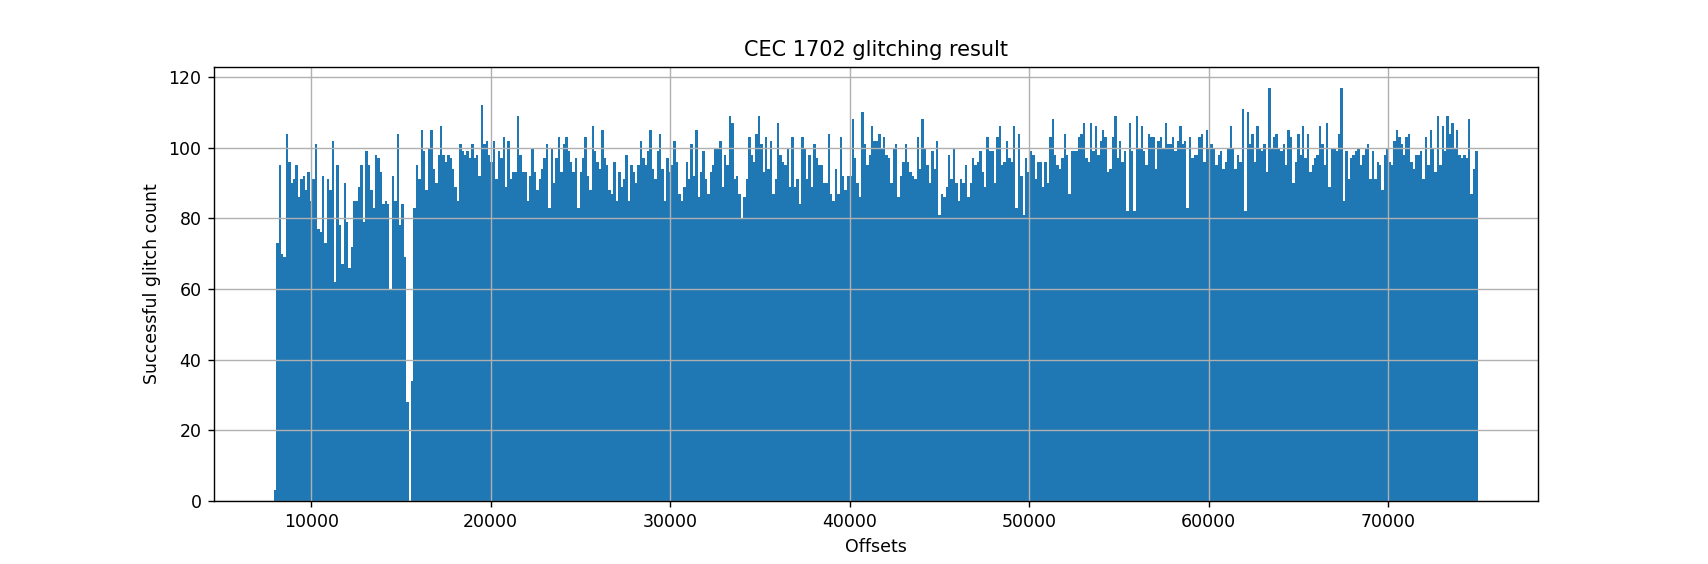

In [16]:
print_results()

Done glitching:
- total_success   = 37152
- total_normal    = 32480
- total_reset     = 5235
- total_UFO_reset = 117
- total_false_s   = 134
- offset count    = 75001
- duration        = 07:54:45.05


<IPython.core.display.Javascript object>


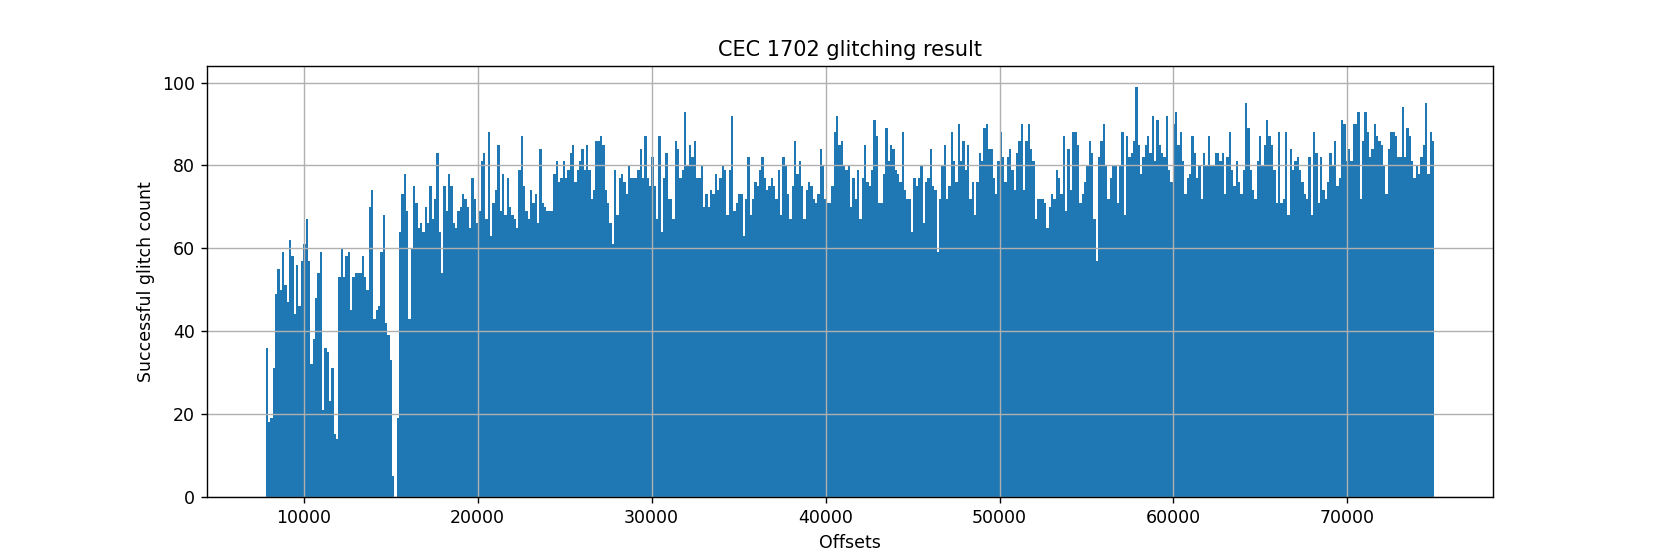

In [56]:
print_results()

### 6. Save the information about successful glitching

In [17]:
FILE_NAME = "w48_o-41_r9"

In [18]:
%%sh -s "$FILE_NAME"
cd CEC_GLITCHING
touch info_$1.txt
touch offsets_$1.txt
echo "files created"

files created


In [19]:
import numpy as np
np_succesful_offsets = np.array(succesful_offsets)
np.savetxt("CEC_GLITCHING/offsets_" + FILE_NAME + ".txt", np_succesful_offsets, fmt='%d', delimiter = ',')
print("files filled with data")

with open("CEC_GLITCHING/info_" + FILE_NAME + ".txt", 'w') as f:
    f.write(f'OFFSET_START = {OFFSET_START}\n')
    f.write(f'OFFSET_END   = {OFFSET_END}  \n')
    f.write(f'-----------------------------\n')
    f.write(f'N   = {n}\n')
    f.write(f'CT  = {c}\n')
    f.write(f'-----------------------------\n')
    f.write(f"- total_success   = {total_success}\n")
    f.write(f"- total_normal    = {total_normal}\n")
    f.write(f"- total_reset     = {total_reset}\n")
    f.write(f"- total_UFO_reset = {total_UFO_reset}\n")
    f.write(f"- total_false_s   = {total_false_success}\n")
    f.write(f"- offset count    = {OFFSET_END - OFFSET_START + 1}\n")
    f.write(f"- duration        = {timer(loop_start_time, loop_end_time)}\n")

files filled with data


**NOTE: You'll need to disconnect the scope/target before connecting again, like you would in another notebook. This can be done with `scope.dis()` and `target.dis()`**

In [87]:
scope.dis()
target.dis()